In [3]:
import pandas as pd
import datetime
import argparse
from scipy import sparse
import scipy.io
from scipy.stats import zscore, rankdata
from sklearn.preprocessing import binarize
from sklearn import metrics
from itertools import cycle
import os
import pickle
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import sys
import re
import math
import datetime
from scipy.spatial import distance
from scipy.cluster import hierarchy
import scanpy as sc
from itertools import combinations
from copy import deepcopy
import collections
# import episcanpy as epi
import functools

In [44]:
print(sc.__version__)
top_dir = "../data/bam_p_cd4/"

1.10.3


## Data setup 1
* from bam files

In [5]:
for filt in ['raw', 'filtered'][0:2]:
    all_cells = []
    global_start = 0
    for batch_num in range(4, 8):
        print(all_cells)
        batch = "30526"+str(batch_num)
        base_dir = os.path.join(top_dir, batch+'Solo.out', 'Gene', filt)
        barcodes = pd.read_csv(os.path.join(base_dir, 'barcodes.tsv'), header=None)
        barcodes.index = list(map(str, range(global_start, global_start+barcodes.shape[0])))
        features = pd.read_csv(os.path.join(base_dir, 'features.tsv'), header=None, sep='\t')
        features.columns = ['id', 'symbol']
        matrix   = scipy.io.mmread(os.path.join(base_dir, 'matrix.mtx'))
        print(barcodes)
        print(features)
        print(matrix.shape)
        print(matrix.sum(axis=0).shape, matrix.sum(axis=1).shape)
        barcodes.columns = ['barcode']
        barcodes = barcodes.assign(batch=[batch for x in range(barcodes.shape[0])])
        barcodes = barcodes.assign(cov=np.array(matrix.sum(axis=0)).reshape(-1))
        features = features.assign(cov=np.array(matrix.sum(axis=1)).reshape(-1))
        adata = sc.AnnData(matrix.tocsr().transpose(), obs=barcodes, var=features)
        all_cells.append(adata)
        global_start += barcodes.shape[0]
    all_cells = all_cells[0].concatenate(*(all_cells[1:len(all_cells)]), join='inner', index_unique='-')
    print(all_cells)
    all_cells.var = all_cells.var.assign(cov=all_cells.var.loc[:, all_cells.var.columns.str.startswith('cov')].sum(axis=1))
    all_cells.var = all_cells.var.loc[:,[c for c in all_cells.var.columns if 'cov-' not in c]]
    all_cells.var = all_cells.var.astype('category')
    all_cells = all_cells[~all_cells.obs.index.isna(),:]
    all_cells = all_cells[:,~all_cells.var.index.isna()]
    all_cells.var = all_cells.var.set_index('id')
    print(all_cells)
    header = 'scarmadillo_'+filt
    with open('scarmadillo_'+filt+'_scobj.pyn','wb') as f:
        pickle.dump(all_cells, f)

[]
                        0
0        AAACCCAAGAAACACT
1        AAACCCAAGAAACCAT
2        AAACCCAAGAAACCCA
3        AAACCCAAGAAACCCG
4        AAACCCAAGAAACCTG
...                   ...
6794875  TTTGTTGTCTTTGCTA
6794876  TTTGTTGTCTTTGCTG
6794877  TTTGTTGTCTTTGGAG
6794878  TTTGTTGTCTTTGGCT
6794879  TTTGTTGTCTTTGTCG

[6794880 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174
33471                  CD4                  CD4

[33472 rows x 2 columns]
(33472, 6794880)
(1, 6794880) (33472, 1)


/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[AnnData object with n_obs × n_vars = 6794880 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov']
                         0
6794880   AAACCCAAGAAACACT
6794881   AAACCCAAGAAACCAT
6794882   AAACCCAAGAAACCCA
6794883   AAACCCAAGAAACCCG
6794884   AAACCCAAGAAACCTG
...                    ...
13589755  TTTGTTGTCTTTGCTA
13589756  TTTGTTGTCTTTGCTG
13589757  TTTGTTGTCTTTGGAG
13589758  TTTGTTGTCTTTGGCT
13589759  TTTGTTGTCTTTGTCG

[6794880 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[AnnData object with n_obs × n_vars = 6794880 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov', AnnData object with n_obs × n_vars = 6794880 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov']
                         0
13589760  AAACCCAAGAAACACT
13589761  AAACCCAAGAAACCAT
13589762  AAACCCAAGAAACCCA
13589763  AAACCCAAGAAACCCG
13589764  AAACCCAAGAAACCTG
...                    ...
20384635  TTTGTTGTCTTTGCTA
20384636  TTTGTTGTCTTTGCTG
20384637  TTTGTTGTCTTTGGAG
20384638  TTTGTTGTCTTTGGCT
20384639  TTTGTTGTCTTTGTCG

[6794880 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[AnnData object with n_obs × n_vars = 6794880 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov', AnnData object with n_obs × n_vars = 6794880 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov', AnnData object with n_obs × n_vars = 6794880 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov']
                         0
20384640  AAACCCAAGAAACACT
20384641  AAACCCAAGAAACCAT
20384642  AAACCCAAGAAACCCA
20384643  AAACCCAAGAAACCCG
20384644  AAACCCAAGAAACCTG
...                    ...
27179515  TTTGTTGTCTTTGCTA
27179516  TTTGTTGTCTTTGCTG
27179517  TTTGTTGTCTTTGGAG
27179518  TTTGTTGTCTTTGGCT
27179519  TTTGTTGTCTTTGTCG

[6794880 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/fp/rc9qnfl53b76r8pj1kppjvr00000gq/T/ipykernel_36218/2169223260.py:24: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_cells = all_cells[0].concatenate(*(all_cells[1:len(all_cells)]), join='inner', index_unique='-')


AnnData object with n_obs × n_vars = 27179520 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov-0', 'cov-1', 'cov-2', 'cov-3'


/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:747: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ENSDNOG00000042816', 'ENSDNOG00000043683', 'ENSDNOG00000018035', 'ENSDNOG00000036192', 'ENSDNOG00000027861']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 27179520 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'symbol', 'cov'
[]
                     0
0     AAACCCACAGCACCCA
1     AAACCCACATGACAAA
2     AAACCCAGTCTGTCAA
3     AAACCCATCCACGTGG
4     AAACGAAAGACCATAA
...                ...
4850  TTTGGTTTCAGTCACA
4851  TTTGGTTTCCGTAGGC
4852  TTTGGTTTCTAGCATG
4853  TTTGTTGAGAAGCCAC
4854  TTTGTTGAGCTAAATG

[4855 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174
33471                  CD4                  CD4

[3347

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[AnnData object with n_obs × n_vars = 4855 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov']
                     0
4855  AAACCCAAGAGATTCA
4856  AAACCCAAGCGCAATG
4857  AAACCCATCGAGAAGC
4858  AAACGAAAGACAAGCC
4859  AAACGAAAGGGTTGCA
...                ...
7960  TTTGTTGAGCAGGGAG
7961  TTTGTTGCACATACGT
7962  TTTGTTGCACTGCTTC
7963  TTTGTTGGTCCTGGTG
7964  TTTGTTGTCCAAGCAT

[3110 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174
33471                  CD4                  CD4

[334

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


                      0
7965   AAACCCAAGAGTCAAT
7966   AAACCCAAGTAATACG
7967   AAACCCACACACAGCC
7968   AAACCCACATCATCTT
7969   AAACGAATCGTCAACA
...                 ...
11448  TTTGGTTCATTCAGGT
11449  TTTGGTTGTTACTCAG
11450  TTTGGTTTCAGCTGTA
11451  TTTGTTGCACGGCTAC
11452  TTTGTTGGTCTTGCGG

[3488 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174
33471                  CD4                  CD4

[33472 rows x 2 columns]
(33472, 3488)
(1, 3488) (33472, 1)
[AnnData object with n_obs × n_vars = 4855 × 33472

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


                      0
11453  AAACCCACATCAACCA
11454  AAACCCACATGACGGA
11455  AAACCCACATGGGATG
11456  AAACCCATCCCACAGG
11457  AAACGAAAGCGAGTCA
...                 ...
16088  TTTGTTGAGCGCATCC
16089  TTTGTTGCACGTGAGA
16090  TTTGTTGCAGAACTCT
16091  TTTGTTGTCATCTACT
16092  TTTGTTGTCTGCGGCA

[4640 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174
33471                  CD4                  CD4

[33472 rows x 2 columns]
(33472, 4640)
(1, 4640) (33472, 1)


/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/fp/rc9qnfl53b76r8pj1kppjvr00000gq/T/ipykernel_36218/2169223260.py:24: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_cells = all_cells[0].concatenate(*(all_cells[1:len(all_cells)]), join='inner', index_unique='-')


AnnData object with n_obs × n_vars = 16093 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov-0', 'cov-1', 'cov-2', 'cov-3'
AnnData object with n_obs × n_vars = 16093 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'symbol', 'cov'


/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:747: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ENSDNOG00000042816', 'ENSDNOG00000043683', 'ENSDNOG00000018035', 'ENSDNOG00000036192', 'ENSDNOG00000027861']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [124]:
for filt in ['raw', 'filtered']:
    all_cells = []
    global_start = 0
    for batch_num in range(4, 8):
        print(all_cells)
        batch = "30526"+str(batch_num)
        base_dir = os.path.join(top_dir, batch+'Solo.out', 'Gene', filt)
        barcodes = pd.read_csv(os.path.join(base_dir, 'barcodes.tsv'), header=None)
        barcodes.index = list(map(str, range(global_start, global_start+barcodes.shape[0])))
        features = pd.read_csv(os.path.join(base_dir, 'features.tsv'), header=None, sep='\t')
        features.columns = ['id', 'symbol']
        matrix   = scipy.io.mmread(os.path.join(base_dir, 'matrix.mtx'))
        print(barcodes)
        print(features)
        print(matrix.shape)
        print(matrix.sum(axis=0).shape, matrix.sum(axis=1).shape)
        barcodes.columns = ['barcode']
        barcodes = barcodes.assign(batch=[batch for x in range(barcodes.shape[0])])
        barcodes = barcodes.assign(cov=np.array(matrix.sum(axis=0)).reshape(-1))
        features = features.assign(cov=np.array(matrix.sum(axis=1)).reshape(-1))
        adata = sc.AnnData(matrix.tocsr().transpose(), obs=barcodes, var=features)
        all_cells.append(adata)
        global_start += barcodes.shape[0]
    all_cells = all_cells[0].concatenate(*(all_cells[1:len(all_cells)]), join='inner', index_unique='-')
    print(all_cells)
    all_cells.var = all_cells.var.assign(cov=all_cells.var.loc[:, all_cells.var.columns.str.startswith('cov')].sum(axis=1))
    all_cells.var = all_cells.var.loc[:,[c for c in all_cells.var.columns if 'cov-' not in c]]
    all_cells.var = all_cells.var.astype('category')
    all_cells = all_cells[~all_cells.obs.index.isna(),:]
    all_cells = all_cells[:,~all_cells.var.index.isna()]
    all_cells.var = all_cells.var.set_index('id')
    print(all_cells)
    header = 'scarmadillo_'+filt
    with open('scarmadillo_'+filt+'_scobj.pyn','wb') as f:
        pickle.dump(all_cells, f)

[]
                     0
0     AAACCCACAGCACCCA
1     AAACCCACATGACAAA
2     AAACCCAGTCTGTCAA
3     AAACCCATCCACGTGG
4     AAACGAAAGACCATAA
...                ...
4850  TTTGGTTTCAGTCACA
4851  TTTGGTTTCCGTAGGC
4852  TTTGGTTTCTAGCATG
4853  TTTGTTGAGAAGCCAC
4854  TTTGTTGAGCTAAATG

[4855 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33466  gSpikein_ERCC-00165  gSpikein_ERCC-00165
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174

[33471 rows x 2 columns]
(33471, 4855)
(1, 4855) (33471, 1)


Transforming to str index.


[AnnData object with n_obs × n_vars = 4855 × 33471 
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov']


Transforming to str index.


                     0
4855  AAACCCAAGAGATTCA
4856  AAACCCAAGCGCAATG
4857  AAACCCATCGAGAAGC
4858  AAACGAAAGACAAGCC
4859  AAACGAAAGGGTTGCA
...                ...
7960  TTTGTTGAGCAGGGAG
7961  TTTGTTGCACATACGT
7962  TTTGTTGCACTGCTTC
7963  TTTGTTGGTCCTGGTG
7964  TTTGTTGTCCAAGCAT

[3110 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33466  gSpikein_ERCC-00165  gSpikein_ERCC-00165
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174

[33471 rows x 2 columns]
(33471, 3110)
(1, 3110) (33471, 1)
[AnnData object with n_obs × n_vars = 4855 × 33471 
    obs: '

Transforming to str index.


                      0
7965   AAACCCAAGAGTCAAT
7966   AAACCCAAGTAATACG
7967   AAACCCACACACAGCC
7968   AAACCCACATCATCTT
7969   AAACGAATCGTCAACA
...                 ...
11448  TTTGGTTCATTCAGGT
11449  TTTGGTTGTTACTCAG
11450  TTTGGTTTCAGCTGTA
11451  TTTGTTGCACGGCTAC
11452  TTTGTTGGTCTTGCGG

[3488 rows x 1 columns]
                        id               symbol
0       ENSDNOG00000042816                 MTDH
1       ENSDNOG00000043683              RF00026
2       ENSDNOG00000018035               TSPYL5
3       ENSDNOG00000036192                  CPQ
4       ENSDNOG00000027861              RF00003
...                    ...                  ...
33466  gSpikein_ERCC-00165  gSpikein_ERCC-00165
33467  gSpikein_ERCC-00168  gSpikein_ERCC-00168
33468  gSpikein_ERCC-00170  gSpikein_ERCC-00170
33469  gSpikein_ERCC-00171  gSpikein_ERCC-00171
33470     gSpikein_phiX174     gSpikein_phiX174

[33471 rows x 2 columns]
(33471, 3488)
(1, 3488) (33471, 1)
[AnnData object with n_obs × n_vars = 4855 × 33471

Transforming to str index.


AnnData object with n_obs × n_vars = 16093 × 33471 
    obs: 'barcode', 'batch', 'cov'
    var: 'id', 'symbol', 'cov-0', 'cov-1', 'cov-2', 'cov-3'
AnnData object with n_obs × n_vars = 16093 × 33471 
    obs: 'barcode', 'batch', 'cov'
    var: 'symbol', 'cov'


## Data setup 2
* From text files
* ../data/geo_metadata/

In [40]:
geo_dir = "../data/geo_metadata/"
tail = ['', '_raw'][1]
matrix = scipy.io.mmread(os.path.join(geo_dir, "GSE273197_scrna_X"+tail+".mtx"))
matrix = sparse.csr_matrix(matrix, dtype=np.float32)
print(sparse.csr_matrix(matrix))
obs = pd.read_csv(os.path.join(geo_dir, "GSE273197_scrna_obs"+tail+".csv"), index_col=0)
var = pd.read_csv(os.path.join(geo_dir, "GSE273197_scrna_var"+tail+".csv"), index_col=0)
all_cells = sc.AnnData(matrix, obs=obs, var=var)
print(all_cells)
with open("scarmadillo_filtered_scobj.pyn", "wb") as f:
    pickle.dump(all_cells, f)

  (np.int32(0), np.int32(42))	1.0
  (np.int32(0), np.int32(61))	1.0
  (np.int32(0), np.int32(99))	1.0
  (np.int32(0), np.int32(134))	1.0
  (np.int32(0), np.int32(150))	1.0
  (np.int32(0), np.int32(195))	1.0
  (np.int32(0), np.int32(212))	1.0
  (np.int32(0), np.int32(248))	3.0
  (np.int32(0), np.int32(301))	1.0
  (np.int32(0), np.int32(342))	1.0
  (np.int32(0), np.int32(345))	1.0
  (np.int32(0), np.int32(414))	1.0
  (np.int32(0), np.int32(417))	2.0
  (np.int32(0), np.int32(432))	1.0
  (np.int32(0), np.int32(490))	1.0
  (np.int32(0), np.int32(611))	1.0
  (np.int32(0), np.int32(629))	1.0
  (np.int32(0), np.int32(648))	1.0
  (np.int32(0), np.int32(666))	1.0
  (np.int32(0), np.int32(670))	1.0
  (np.int32(0), np.int32(696))	1.0
  (np.int32(0), np.int32(720))	1.0
  (np.int32(0), np.int32(732))	1.0
  (np.int32(0), np.int32(740))	1.0
  (np.int32(0), np.int32(764))	2.0
  :	:
  (np.int32(16092), np.int32(32220))	2.0
  (np.int32(16092), np.int32(32224))	5.0
  (np.int32(16092), np.int32(32240))	1.0

In [41]:
def data_preprocess(adata, norm=True, spike_in=True):
    if spike_in:
        spike_in_label = [c for c in adata.var.index if 'Spikein' in c]
        adata.obs = adata.obs.assign(n_counts_spike= adata[:,spike_in_label].X.sum(axis=1))
        a = adata.obs.loc[:,'n_counts_spike']
        print(spike_in_label, a)
        print(np.mean(a), np.max(a), np.min(a))
        adata = adata[:,~adata.var.index.str.startswith('gSpikein')]
        adata.obs = adata.obs.assign(n_counts=adata.X.sum(axis=1)) 
        sns_plot = sns.scatterplot(data=adata.obs, x="n_counts", y="n_counts_spike")
        fig = sns_plot.get_figure()
        fig.savefig("total_spike_correlation.pdf")
    if norm:
        print(adata.shape)
        sc.pp.filter_genes(adata, min_counts=10)
        print(adata.shape)
        sc.pp.normalize_per_cell(adata)
    return adata

def data_postprocess(adata, n_top_genes=2000, output='pca_hvg.pdf'):
    adata.raw = adata
    sc.pp.log1p(adata) # compute log for highly_varibale_genes
    print(adata.var.columns)
    sc.pp.highly_variable_genes(adata, n_top_genes=min(adata.shape[1], n_top_genes))
    print(adata.var.columns)
    sc.tl.pca(adata, use_highly_variable=True)
    sc.pl.pca(adata, save=output)
    return adata

def test_tsne_dimensions(adata, batch_header, color):
    cluster_head = ''
    for nn in [15, 30]:
        for method in ['umap']:
            for pc in [10, 2, 3, 5, 8, 20, 30, 40, 50]:
                sc.pp.neighbors(adata, method=method, n_pcs=pc, n_neighbors=nn)
                sc.tl.umap(adata)            
                sc.pl.umap(adata, color=cluster_head+color, save='_'+batch_header+'_'+str(nn)+'_'+str(pc)+'.png')
                sc.tl.diffmap(adata, n_comps=nn)
                sc.pl.diffmap(adata, color=cluster_head+color, save='_'+batch_header+'_'+str(nn)+'_'+str(pc)+'.png')
                for perplexity in [30, 50, 100]:
                    for learning_rate in [100, 1000]:
                        sc.tl.tsne(adata, n_pcs=pc, perplexity=perplexity, learning_rate=learning_rate)
                        sc.pl.tsne(adata, color=cluster_head+color, save='_'+batch_header+'_'+str(nn)+'_'+str(pc)+'_'+str(perplexity)+'_'+str(learning_rate)+'_'+method+'.pdf')
                        print(adata.obsm['X_tsne'].shape)
                        if adata.obsm['X_tsne'].shape[1] >= 3:
                            sc.pl.tsne(adata, color=cluster_head+color, save='_'+batch_header+'_'+str(nn)+'_'+str(pc)+'_'+str(perplexity)+'_'+str(learning_rate)+'_'+method+'_3d.png', projection='3d')
                        adata.obsm.pop('X_tsne')


In [42]:
def test_hvg_dimensions(adata, batch_header):
    bdata = sc.pp.log1p(adata, copy=True)
    print(bdata)
    print(bdata.uns)
    for n_top_genes in sorted(list(set([1000, 3000, 5000, 10000]))):
        sc.pp.highly_variable_genes(bdata, n_top_genes=min(bdata.shape[1], n_top_genes))
        print(bdata.var.loc[bdata.var.loc[:,'highly_variable'],:])
        print(bdata.var.index)
        sc.tl.pca(bdata, use_highly_variable=True)
        sc.pl.pca(bdata, save='_'+batch_header+'_pca_plot_'+str(n_top_genes)+'.png')
        sc.pl.pca_loadings(bdata, save=batch_header+'_pca_'+str(n_top_genes)+'.png')
        sc.pl.pca_variance_ratio(bdata, save=batch_header+'_pca_var_'+str(n_top_genes)+'.png')
        bdata.obsm.pop('X_pca')
        if n_top_genes > bdata.shape[1]:
            break
            
def check_data_property(adata, batch_header):
    bdata = adata.copy()
    #bdata.var_names_make_unique()
    sc.pp.filter_cells(bdata, min_genes=0)
    sc.pp.filter_genes(bdata, min_cells=0)
    sc.pl.highest_expr_genes(bdata, n_top=20, save='_'+batch_header+'_heg.png')
    #sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_'+batch_header+'_')
    sc.pl.scatter(bdata, x='n_counts', y='n_genes', save='_'+batch_header+'_counts.pdf')
    sc.pl.highly_variable_genes(bdata, save='_'+batch_header+'_hvg.pdf')
    del bdata

def test_dimension_reduction(adata, batch_header):
    adata = data_preprocess(adata)
    color = 'batch'
    # test_hvg_dimensions(adata, batch_header)
    adata = data_postprocess(adata, 2000, '_'+batch_header+'_pca_plot.pdf')
    # test_tsne_dimensions(adata, batch_header, color)
    check_data_property(adata, batch_header)
    return adata
    


AnnData object with n_obs × n_vars = 16093 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'symbol', 'cov'
                                  symbol    cov
id                                             
ENSDNOG00000042816                  MTDH  13338
ENSDNOG00000043683               RF00026      0
ENSDNOG00000018035                TSPYL5     44
ENSDNOG00000036192                   CPQ    119
ENSDNOG00000027861               RF00003      0
...                                  ...    ...
gSpikein_ERCC-00168  gSpikein_ERCC-00168      0
gSpikein_ERCC-00170  gSpikein_ERCC-00170      0
gSpikein_ERCC-00171  gSpikein_ERCC-00171      0
gSpikein_phiX174        gSpikein_phiX174     15
CD4                                  CD4   2302

[33472 rows x 2 columns]
                  barcode  batch   cov
0-0      AAACCCACAGCACCCA      0  3151
1-0      AAACCCACATGACAAA      0  1999
2-0      AAACCCAGTCTGTCAA      0  6498
3-0      AAACCCATCCACGTGG      0  2628
4-0      AAACGAAAGACCATAA      0  3841
...  

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


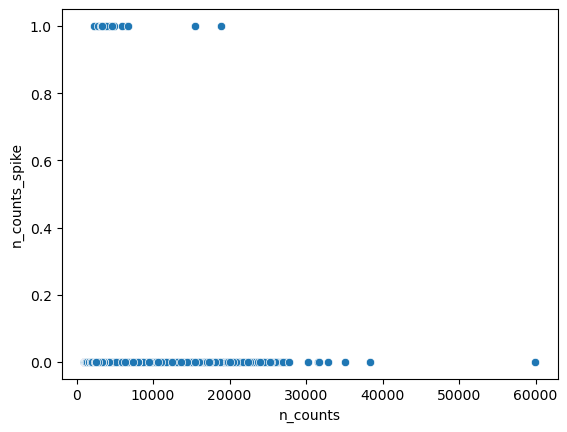

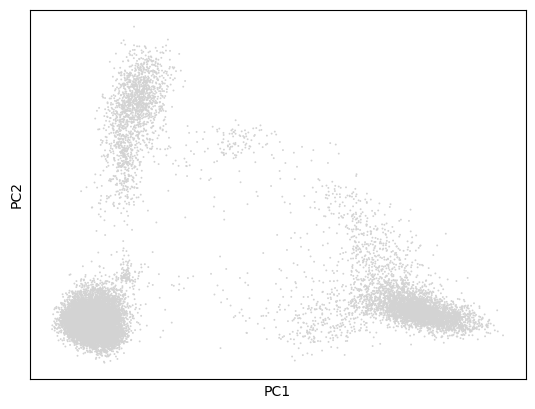

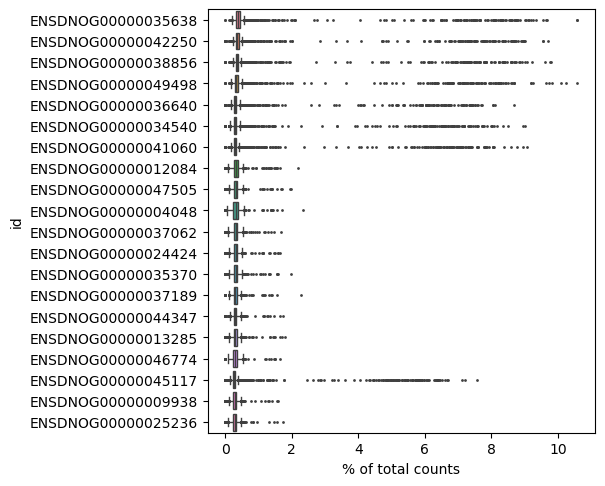

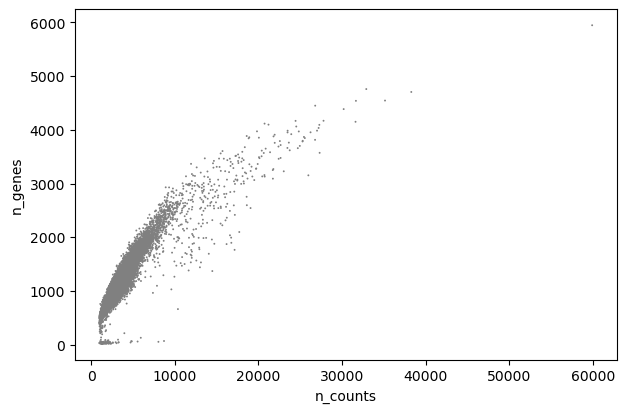

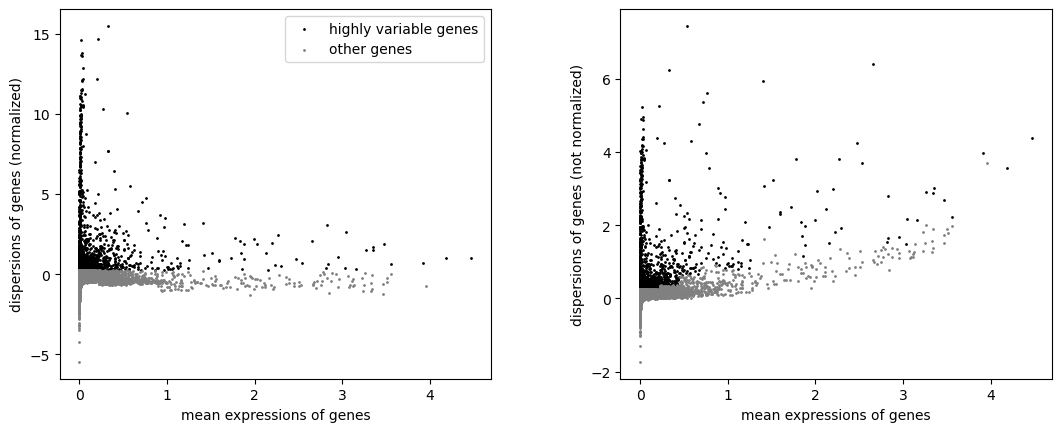

In [43]:
for filt in ['raw', 'filtered'][1:2]:
    with open('scarmadillo_'+filt+'_scobj.pyn','rb') as f:
        all_cells = pickle.load(f)
        print(all_cells)
        print(all_cells.var)
        print(all_cells.obs)
        print(all_cells.X.shape)
        # all_cells.var = all_cells.var.set_index('symbol')
        test_dimension_reduction(all_cells, 'scarmadillo_'+filt)

AnnData object with n_obs × n_vars = 16093 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'symbol', 'cov'
                                  symbol    cov  n_cells
id                                                      
ENSDNOG00000042816                  MTDH  13338     7426
ENSDNOG00000018035                TSPYL5     44       35
ENSDNOG00000036192                   CPQ    119      103
ENSDNOG00000001330                PTDSS1    135      133
ENSDNOG00000041739                MTERF3    449      431
...                                  ...    ...      ...
ENSDNOG00000042957    ENSDNOG00000042957      6        6
ENSDNOG00000044297    ENSDNOG00000044297   1046      883
gSpikein_ERCC-00054  gSpikein_ERCC-00054      1        1
gSpikein_phiX174        gSpikein_phiX174     15       15
CD4                                  CD4   2302     1862

[20530 rows x 3 columns]
                  barcode  batch   cov  n_genes
0-0      AAACCCACAGCACCCA      0  3151     1134
1-0      AAACCCACATGACAAA 

/var/folders/fp/rc9qnfl53b76r8pj1kppjvr00000gq/T/ipykernel_36218/2886896120.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p1 = sns.distplot(all_cells.obs['n_genes'], kde=False)


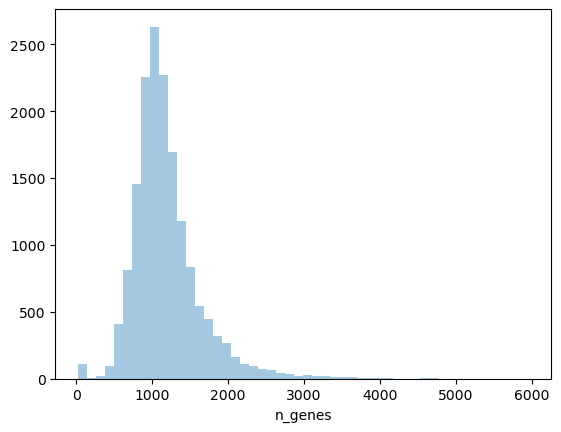

/var/folders/fp/rc9qnfl53b76r8pj1kppjvr00000gq/T/ipykernel_36218/2886896120.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p2 = sns.distplot(all_cells.var['cov'].map(math.log10), kde=False)


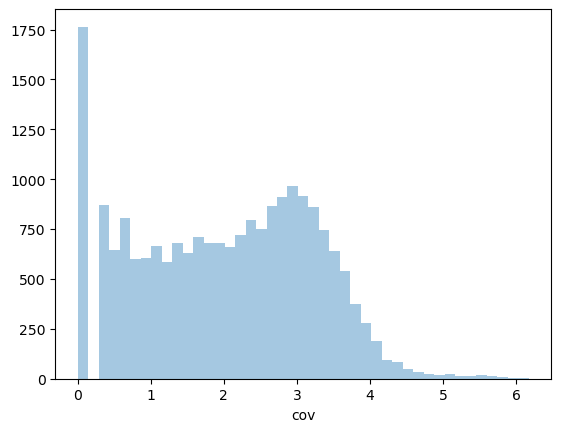

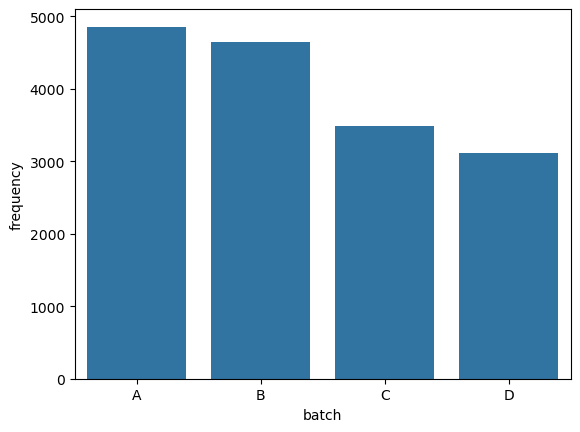

In [31]:
import math

for filt in ['raw', 'filtered'][1:2]:
    with open('scarmadillo_'+filt+'_scobj.pyn','rb') as f:
        all_cells = pickle.load(f)
        print(all_cells)
        sc.pp.filter_cells(all_cells, min_genes=1)
        sc.pp.filter_genes(all_cells, min_cells=1)
        print(all_cells.var)
        print(all_cells.obs)
        print(all_cells.X.shape)
        p1 = sns.distplot(all_cells.obs['n_genes'], kde=False)
        p1.get_figure().savefig('dist_ngenes_'+filt+'.pdf')
        plt.show()
        p2 = sns.distplot(all_cells.var['cov'].map(math.log10), kde=False)
        p2.get_figure().savefig('dist_cov_'+filt+'.pdf')
        plt.show()
        df = all_cells.obs['batch'].value_counts()
        df = df.reset_index()
        df.columns = ['batch', 'frequency'] 
        df.batch = ['A', 'B', 'C', 'D']
        p3 = sns.barplot(data=df, x='batch', y='frequency')
        # p3.legend_.remove()
        p3.get_figure().savefig('bar_batch_ccount'+filt+'.pdf')
        plt.show()
        

In [ ]:
print('test')

In [11]:
def add_dimension_reduction(adata, batch_header, resolution=None):  
    adata = data_preprocess(adata)
    print(adata)
    color = 'batch'
    n_top_genes, pc, nn, perplexity, learning_rate = 2000, 50, 30, 30, 100
    adata = data_postprocess(adata, n_top_genes, '_'+batch_header+'_pca_plot.png')
    print(adata)
    sc.pl.pca_loadings(adata, save=batch_header+'_pca.png')
    sc.pl.pca_variance_ratio(adata, save=batch_header+'_pca_var.png')
    sc.pp.neighbors(adata, n_neighbors=nn, n_pcs=pc, method='umap')
    sc.tl.umap(adata)
    sc.tl.tsne(adata, n_pcs=pc, perplexity=perplexity, learning_rate=learning_rate)
    check_data_property(adata, batch_header)
    adata.X = adata.raw.X
    adata.obs['tsne1'] = adata.obsm['X_tsne'][:,0]
    adata.obs['tsne2'] = adata.obsm['X_tsne'][:,1]
    adata.obs['umap1'] = adata.obsm['X_umap'][:,0]
    adata.obs['umap2'] = adata.obsm['X_umap'][:,1]
    sc.tl.louvain(adata, resolution=resolution, copy=False, key_added='cluster_louvain')
    sc.tl.leiden(adata, resolution=resolution, copy=False, key_added='cluster_leiden')
    return adata

def plot_ranking_genes(adata, batch_header, cluster=['cluster_louvain', 'cluster_leiden', 'celltype']):
    for color in cluster:
        assigned_cells = [c for c in set(adata.obs[color]) if (adata[adata.obs[color] == c].shape[0] > 1) and c == c]
        tdata = adata[[(c in assigned_cells) for c in adata.obs[color]], :]
        sc.tl.rank_genes_groups(tdata, groupby=color, method='wilcoxon', n_genes=10000)
        df = pd.DataFrame([list(x) for x in tdata.uns['rank_genes_groups']['names']])
        df.columns = tdata.obs[color].cat.categories
        df.to_csv(batch_header+"_rank_genes_"+color+'.csv')
        sc.pl.rank_genes_groups(tdata, n_genes=15, save=batch_header+"_rank_genes_"+color+".pdf")
        del tdata.uns['rank_genes_groups']

def plot_tsne_and_umap(adata, batch_header, label, cluster=['cluster_louvain', 'cluster_leiden', 'celltype']):
    for color in cluster+['cov', 'batch']:
        palette = None
        for loc in ['on data', 'right margin']:
            print(color, label)
            ofile = os.path.join(batch_header+"_ori_"+label+"_"+color+("_on" if loc == 'on data' else '')+".pdf")
            kwargs = {'edgecolor':None, 'alpha':0.4}
            sc.pl.scatter(adata, x=label+'1', y=label+'2', color=color, palette=palette, legend_loc=loc, save=ofile)
            
def analyze_and_visualize(adata, batch_header, resolution=None):
    for label in ['tsne', 'umap']:
        plot_tsne_and_umap(adata, batch_header, label)
        #plot_marker_genes_embedded(adata, out, label, markers)
        #self.plot_agg_marker_genes(adata, out, markers)
    plot_ranking_genes(adata, batch_header)

In [ ]:
for filt in ['raw', 'filtered'][0:2]:
    all_cells = None
    with open('scarmadillo_'+filt+'_scobj.pyn','rb') as f:
        all_cells = pickle.load(f)
        all_cells.var = all_cells.var.reset_index().set_index('id')
        print(all_cells.var)
        all_cells = add_dimension_reduction(all_cells, 'scarmadillo_'+filt)
    print(all_cells.var)
    if all_cells is None: continue
    with open('scarmadillo_'+filt+'_modf_scobj.pyn', 'wb') as f:
        pickle.dump(all_cells, f)

/Users/Cawa/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ENSDNOG00000042816', 'ENSDNOG00000043683', 'ENSDNOG00000018035', 'ENSDNOG00000036192', 'ENSDNOG00000027861']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


                                  symbol    cov
id                                             
ENSDNOG00000042816                  MTDH  13955
ENSDNOG00000043683               RF00026      0
ENSDNOG00000018035                TSPYL5     45
ENSDNOG00000036192                   CPQ    144
ENSDNOG00000027861               RF00003      0
...                                  ...    ...
gSpikein_ERCC-00165  gSpikein_ERCC-00165      0
gSpikein_ERCC-00168  gSpikein_ERCC-00168      0
gSpikein_ERCC-00170  gSpikein_ERCC-00170      0
gSpikein_ERCC-00171  gSpikein_ERCC-00171      0
gSpikein_phiX174        gSpikein_phiX174     26

[33471 rows x 2 columns]
['gSpikein_ERCC-00002', 'gSpikein_ERCC-00003', 'gSpikein_ERCC-00004', 'gSpikein_ERCC-00007', 'gSpikein_ERCC-00009', 'gSpikein_ERCC-00012', 'gSpikein_ERCC-00013', 'gSpikein_ERCC-00014', 'gSpikein_ERCC-00016', 'gSpikein_ERCC-00017', 'gSpikein_ERCC-00018', 'gSpikein_ERCC-00019', 'gSpikein_ERCC-00022', 'gSpikein_ERCC-00023', 'gSpikein_ERCC-00024', 'gSp

/Users/Cawa/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [33]:
def assign_celltype_by_tsne(x):
    return ['CD4+ T', 'CD14+ Mono', 'CD14+ Mono', 'CD4+ Memory', 'CD4+ Memory', \
    'CD4+ T', 'CD8+ T', 'B', 'CD8+ T', 'B', 'CD4+ T', 'CD14+ Mono', 'B', 'CD14+ Mono', 'DC|FCGR3A+ Mono', 'CD14+ Mono'][int(x)]


... storing 'celltype' as categorical


AnnData object with n_obs × n_vars = 16093 × 15413 
    obs: 'barcode', 'batch', 'cov', 'n_counts_spike', 'n_counts', 'tsne1', 'tsne2', 'umap1', 'umap2', 'cluster_louvain', 'cluster_leiden'
    var: 'symbol', 'cov', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
cluster_louvain tsne


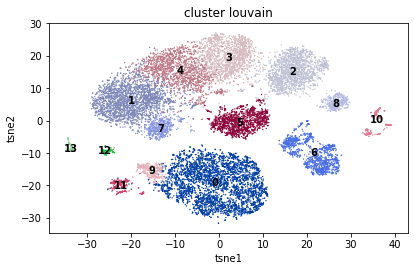

cluster_louvain tsne


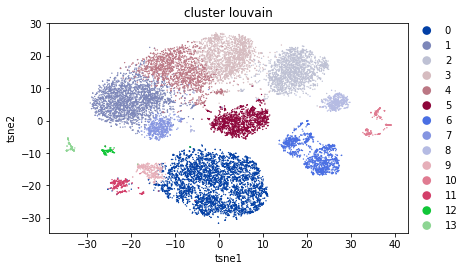

cluster_leiden tsne


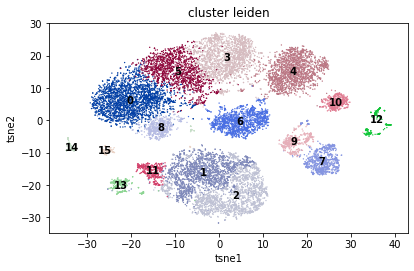

cluster_leiden tsne


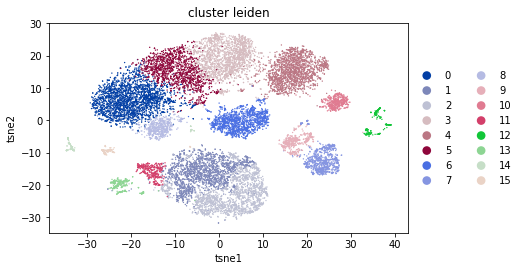

celltype tsne


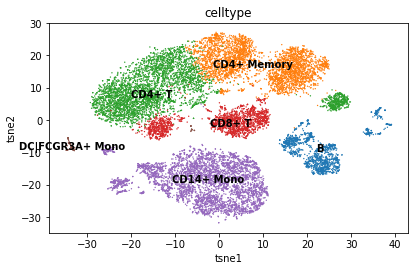

celltype tsne


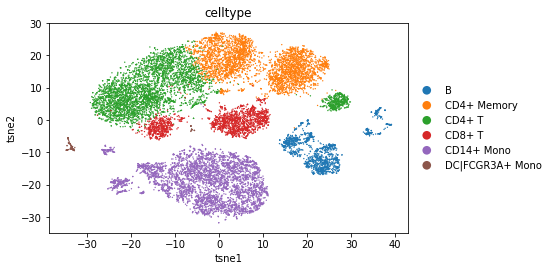

cov tsne


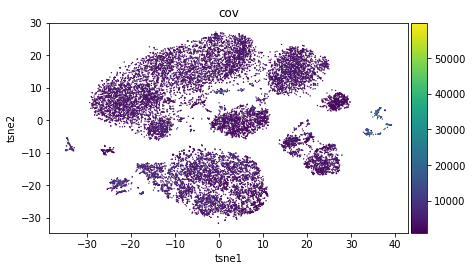

cov tsne


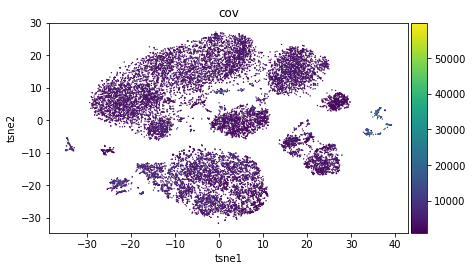

batch tsne


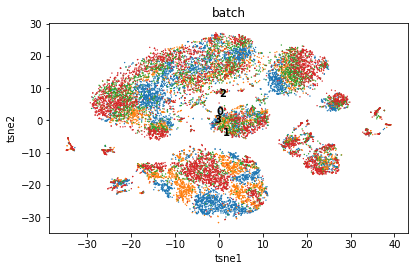

batch tsne


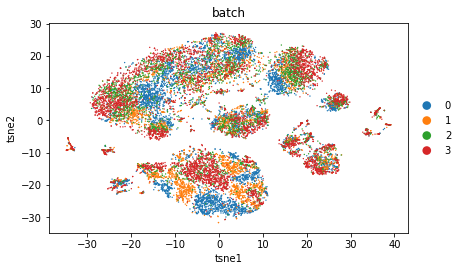

cluster_louvain umap


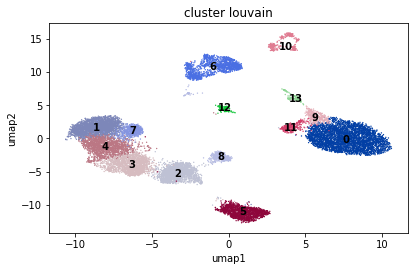

cluster_louvain umap


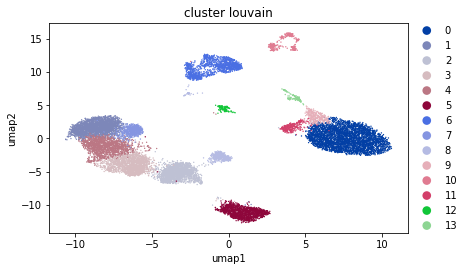

cluster_leiden umap


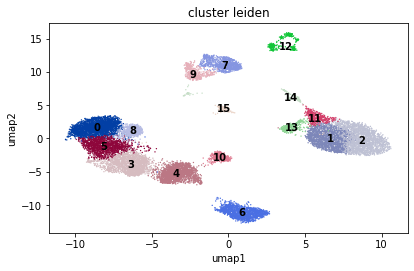

cluster_leiden umap


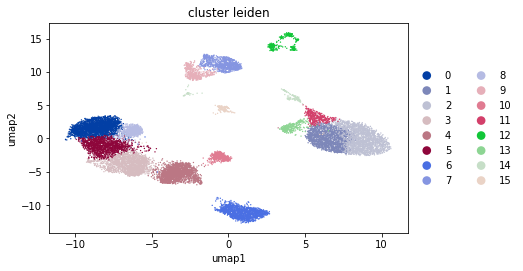

celltype umap


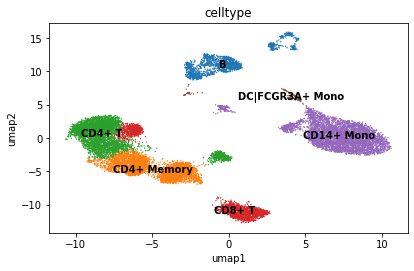

celltype umap


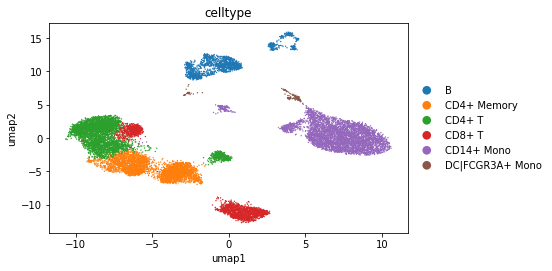

cov umap


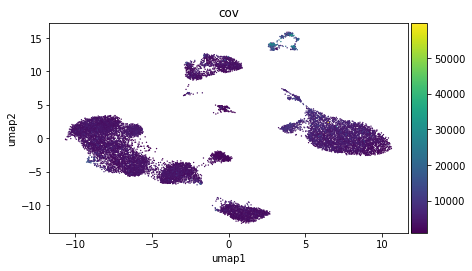

cov umap


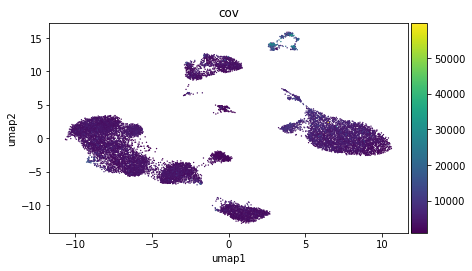

batch umap


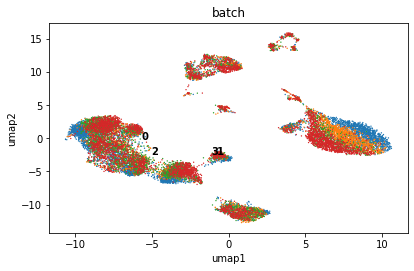

batch umap


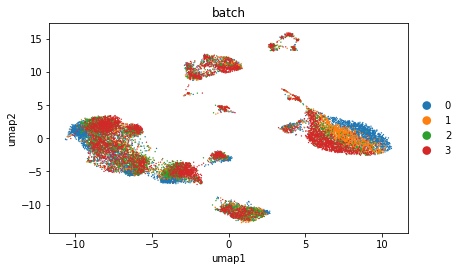

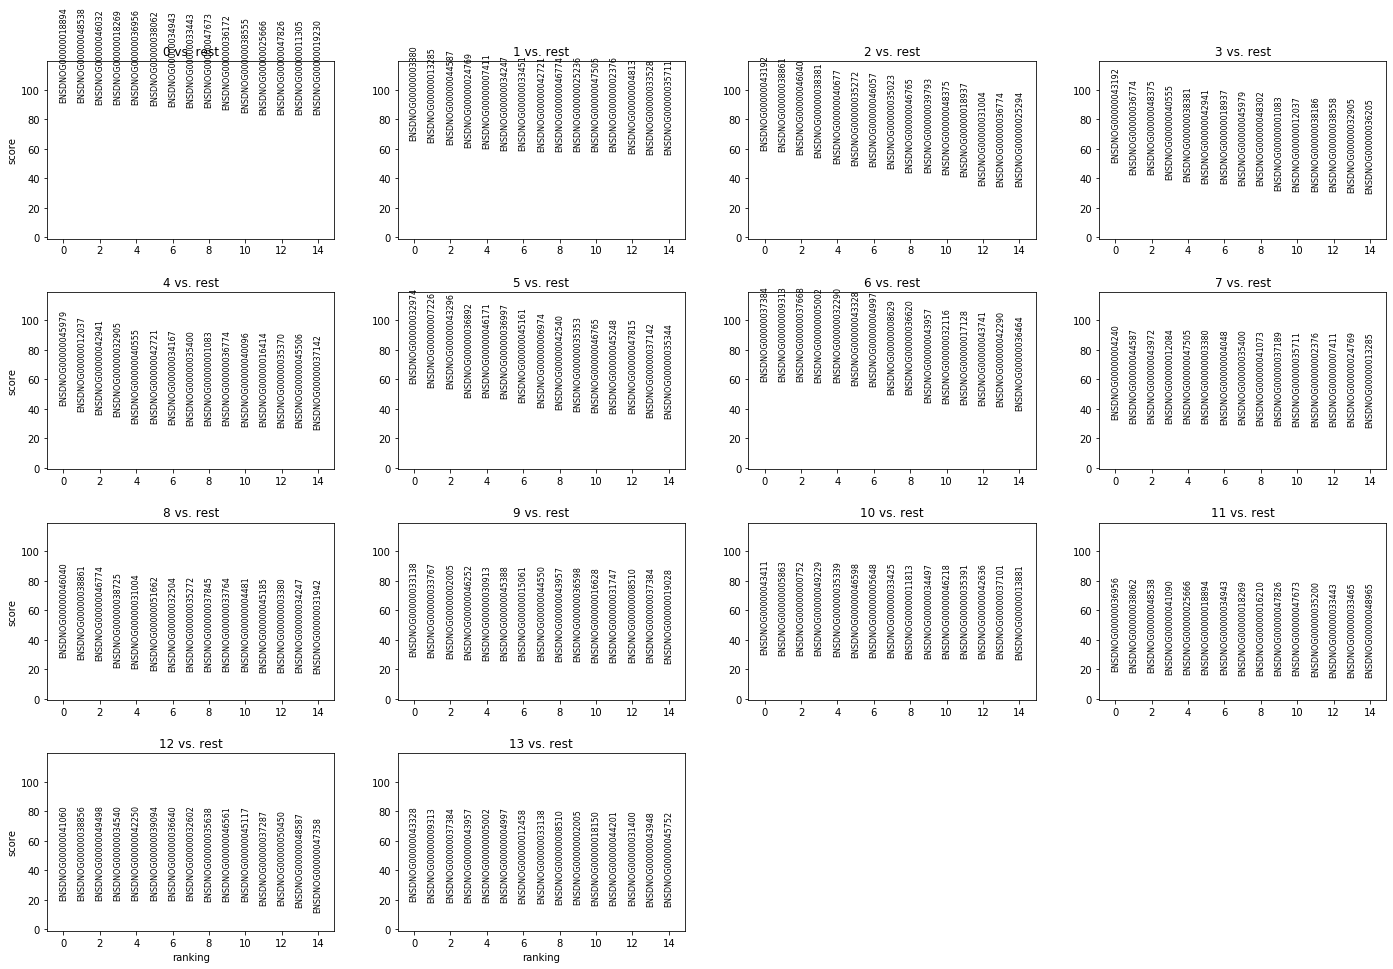

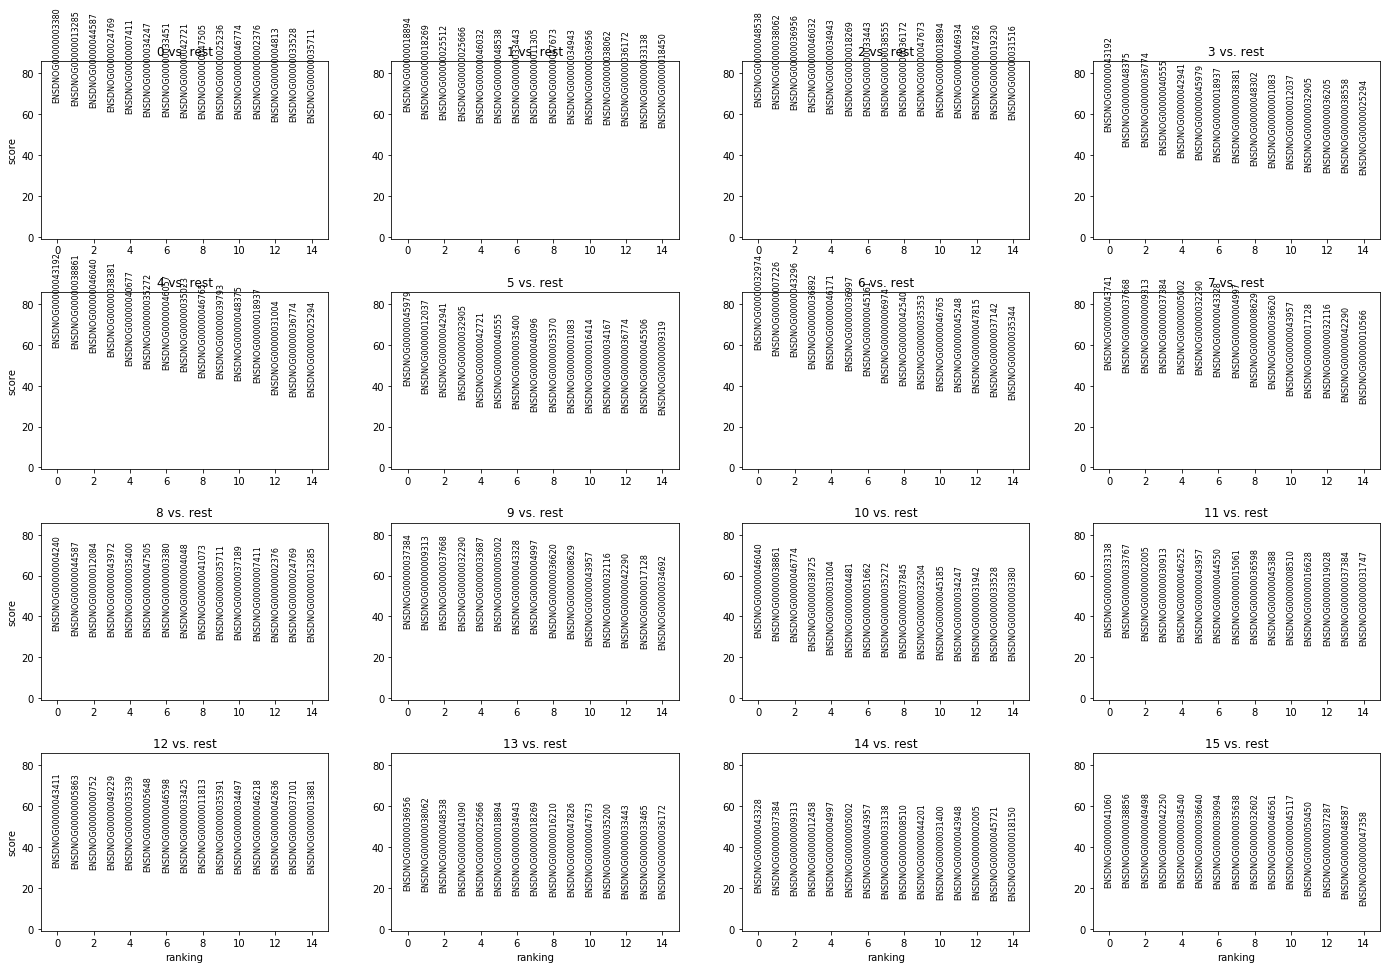

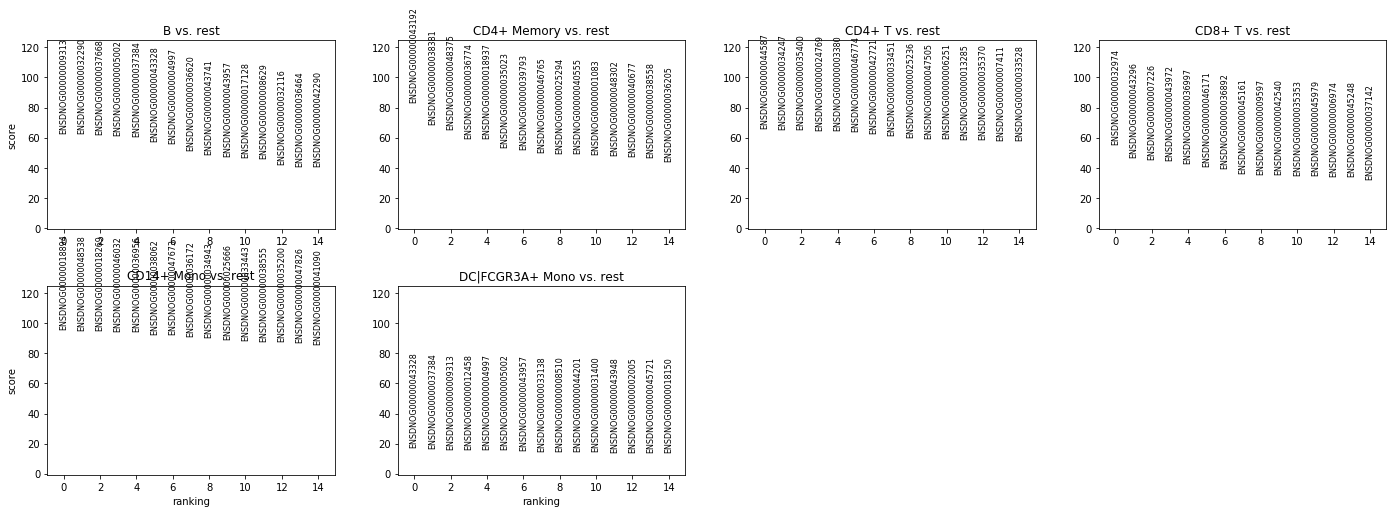

In [34]:
for filt in ['raw', 'filtered'][1:2]:
    all_cells = None
    with open('scarmadillo_'+filt+'_modf_scobj.pyn', 'rb') as f:
        all_cells = pickle.load(f)
        print(all_cells)
    all_cells.obs.loc[:,'celltype'] = [assign_celltype_by_tsne(x) for x in all_cells.obs.loc[:,'cluster_leiden']]
    analyze_and_visualize(all_cells, 'scarmadillo_'+filt)

   batch         celltype  count   percent
0      0                B    369  0.076004
1      0      CD4+ Memory   1111  0.228836
2      0           CD4+ T   1322  0.272297
3      0           CD8+ T    512  0.105458
4      0       CD14+ Mono   1519  0.312873
5      0  DC|FCGR3A+ Mono     22  0.004531
6      1                B    280  0.090032
7      1      CD4+ Memory    541  0.173955
8      1           CD4+ T    553  0.177814
9      1           CD8+ T    425  0.136656
10     1       CD14+ Mono   1250  0.401929
11     1  DC|FCGR3A+ Mono     61  0.019614
12     2                B    323  0.092603
13     2      CD4+ Memory   1031  0.295585
14     2           CD4+ T   1112  0.318807
15     2           CD8+ T    488  0.139908
16     2       CD14+ Mono    518  0.148509
17     2  DC|FCGR3A+ Mono     16  0.004587
18     3                B    660  0.142241
19     3      CD4+ Memory    929  0.200216
20     3           CD4+ T   1252  0.269828
21     3           CD8+ T    513  0.110560
22     3   

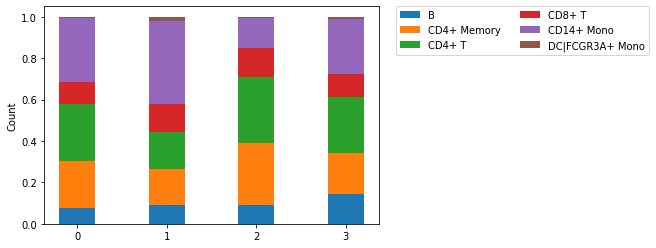

<Figure size 432x288 with 0 Axes>

In [ ]:
celltype_ratio = all_cells.obs.loc[:, ['batch', 'celltype']].groupby(['batch', 'celltype']).size()
celltype_ratio = celltype_ratio.reset_index()
celltype_ratio = celltype_ratio.assign(percent=celltype_ratio.groupby(['batch']).transform(lambda x: x/sum(x)))
celltype_ratio.columns = ['batch', 'celltype', 'count', 'percent']
print(celltype_ratio)
plots = []
stacked = np.array([0, 0, 0, 0])
for i in range(0, 4):
    print(celltype_ratio.loc[celltype_ratio.loc[:,'batch'] == str(i),'percent'].sum())
for c in celltype_ratio.loc[:,'celltype'].unique():
    temp = celltype_ratio.loc[celltype_ratio.loc[:,'celltype'] == c,:]
    print(temp)
    plots.append(plt.bar(temp.loc[:,'batch'], temp.loc[:,'percent'], 0.4, bottom=stacked))
    print(stacked)
    if stacked is None:
        stacked = temp.loc[:, 'percent'].values
    else:
        stacked = stacked + temp.loc[:,'percent'].values

plt.ylabel('Count')
plt.legend((x[0] for x in plots), tuple(celltype_ratio.loc[:,'celltype'].unique()), bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
plt.show()
plt.savefig('batch_celltype_ratio.pdf', bbox_inches='tight')
plt.close('all')
plt.clf()

In [57]:
def plot_seaborn_scatter(data, x, y, hue, out, kwargs, annot=False):
    data = data.sort_values(hue)
    if True:
        plt.figure(figsize=(10,5.5))
        ax = plt.scatter(data.loc[:,x], data.loc[:,y],
                         c=data.loc[:,hue], cmap=plt.get_cmap('RdYlBu_r'), s=3.5)
        plt.colorbar(ax)
        plt.title("Gene: "+hue)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
        plt.savefig(out, bbox_inches='tight')
    else:
        ax = sns.scatterplot(x=x, y=y, data=data, hue=hue, s=3.5, **kwargs)
        ax.set_title("Gene: "+hue)
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
        if annot:
            for line in range(0, data.shape[0]):
                ax.text(data.iloc[line,:][x], data.iloc[line,:][y], str(line), horizontalalignment='left', size='small', color='black')
        fig = ax.get_figure()
        fig.savefig(out, bbox_inches='tight')
    plt.close()
    plt.clf()

def plot_one_gene(ub, adata, out):
    label = "tsne"
    df = pd.DataFrame({'x':all_cells.obs.loc[:,label+"1"], 'y':adata.obs.loc[:,label+"2"], ub:np.log10(1+adata[:,adata.var.loc[:,'symbol'] == ub].X.astype(float))})
    df = df.sort_values(ub, ascending=True)
    print(df.loc[:,ub])
    plot_seaborn_scatter(df, "x", "y", ub, os.path.join("./figures", out+"_"+label+"_"+ub+".pdf"), {'palette':plt.get_cmap('RdYlBu_r'), 'linewidth':0, 'alpha':1.0})

for filt in ['raw', 'filtered'][1:2]:
    all_cells = None
    with open('scarmadillo_'+filt+'_modf_scobj.pyn', 'rb') as f:
        all_cells = pickle.load(f)
        print(all_cells)
        print(all_cells.var)
        #all_cells.var = all_cells.var.reset_index().set_index('symbol')
        print('?????')
        print(all_cells.var_names)
        marker_list = [['IL7R', 'CCR7', 'S100A4', 'CD14', 'LYZ', 'MS4A1', 'CD8A', 'FCGR3A', 'MS4A7', 'GNLY', 'NKG7', 'FCER1A', 'CST3', 'PPBP'], \
                       ['CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1', 'FCGR3A', 'FCER1A', 'CST3'], ['S100A4', 'MS4A1', 'IL7R']]
        marker_list.append([y for x in marker_list for y in x])
        for i, marker in enumerate(marker_list):
            break
            print(len(marker))
            marker = [x for x in marker if x in all_cells.var.loc[:,'symbol'].values]
            marker = list(set(marker))
            print(len(marker), marker)
            marker_name = ['seurat', 'scanpy', 'some', 'all']
            ax = sc.pl.stacked_violin(all_cells, marker, gene_symbols='symbol', groupby='cluster_leiden', swap_axes=True, dendrogram=True, save='marker_plot_'+filt+'_'+marker_name[i]+'_marker.png')
            ax = sc.pl.stacked_violin(all_cells, marker, gene_symbols='symbol', figsize=((5, 9.5) if marker_name[i] != 'some' else (5, 4)), groupby='cluster_leiden', swap_axes=True, dendrogram=True, save='marker_plot_'+filt+'_'+marker_name[i]+'_marker.pdf')
            ax = sc.pl.heatmap(all_cells, marker, gene_symbols='symbol', groupby='cluster_leiden', log=True, save='heatmap_'+filt+'_'+marker_name[i]+'_marker.png')
        marker = marker_list[-1]
        marker = [x for x in marker if x in all_cells.var.loc[:,'symbol'].values]
        marker = list(set(marker))
        for ub in marker:
            plot_one_gene(ub, all_cells, 'exp_'+filt)


AnnData object with n_obs × n_vars = 16093 × 15413 
    obs: 'barcode', 'batch', 'cov', 'n_counts_spike', 'n_counts', 'tsne1', 'tsne2', 'umap1', 'umap2', 'cluster_louvain', 'cluster_leiden'
    var: 'symbol', 'cov', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
                                symbol    cov  n_counts  highly_variable  \
id                                                                         
ENSDNOG00000042816                MTDH  13338   13338.0            False   
ENSDNOG00000018035              TSPYL5     44      44.0             True   
ENSDNOG00000036192                 CPQ    119     119.0            False   
ENSDNOG00000001330              PTDSS1    135     135.0            False   
ENSDNOG00000041739              MTERF3    449     449.0            False   
...                                ...    ...       ...              ...   

8046-2     0.000000
4929-1     0.000000
4927-1     0.000000
10949-2    0.000000
4925-1     0.000000
             ...   
8751-2     1.957636
4983-1     1.969214
7254-1     1.981346
10376-2    2.065745
6065-1     2.085275
Name: S100A4, Length: 16093, dtype: float64


0-0        0.000000
10315-2    0.000000
10316-2    0.000000
10318-2    0.000000
10319-2    0.000000
             ...   
13048-3    1.459992
11807-3    1.473236
12079-3    1.498944
14812-3    1.502941
14907-3    1.568694
Name: MS4A1, Length: 16093, dtype: float64


0-0        0.000000
10692-2    0.000000
10693-2    0.000000
10694-2    0.000000
10695-2    0.000000
             ...   
7474-1     1.137281
12271-3    1.144127
15863-3    1.149407
7275-1     1.168520
9676-2     1.197554
Name: FCER1A, Length: 16093, dtype: float64


0-0        0.000000
9721-2     0.000000
9722-2     0.000000
9724-2     0.000000
9725-2     0.000000
             ...   
15671-3    2.159820
10206-2    2.196142
15918-3    2.235789
11505-3    2.257809
15661-3    2.320735
Name: CST3, Length: 16093, dtype: float64


8046-2     0.000000
7040-1     0.000000
13337-3    0.000000
13335-3    0.000000
7044-1     0.000000
             ...   
11020-2    1.196607
14113-3    1.209383
15553-3    1.212292
3919-0     1.280251
7947-1     1.315594
Name: IL7R, Length: 16093, dtype: float64


0-0        0.000000
10719-2    0.000000
10720-2    0.000000
10721-2    0.000000
10722-2    0.000000
             ...   
8165-2     0.379588
11733-3    0.439737
8650-2     0.466504
8347-2     0.503584
512-0      0.626742
Name: MS4A7, Length: 16093, dtype: float64


0-0        0.000000
10077-2    0.000000
10078-2    0.000000
10079-2    0.000000
10080-2    0.000000
             ...   
12091-3    1.380672
14757-3    1.382948
14841-3    1.407035
2951-0     1.407266
13384-3    1.462895
Name: CD79A, Length: 16093, dtype: float64


0-0        0.000000
10301-2    0.000000
10303-2    0.000000
10304-2    0.000000
10305-2    0.000000
             ...   
7331-1     0.998092
7143-1     0.999383
14229-3    1.006903
12103-3    1.009204
3141-0     1.026491
Name: CD8A, Length: 16093, dtype: float64


0-0        0.000000
10666-2    0.000000
10667-2    0.000000
10668-2    0.000000
10669-2    0.000000
             ...   
4880-1     0.523745
14117-3    0.526686
6536-1     0.531750
15337-3    0.552138
3679-0     0.573278
Name: CD14, Length: 16093, dtype: float64


0-0        0.000000
9525-2     0.000000
9527-2     0.000000
9528-2     0.000000
9530-2     0.000000
             ...   
13608-3    1.620242
15325-3    1.644021
13351-3    1.652676
979-0      1.653928
7799-1     1.690514
Name: LGALS3, Length: 16093, dtype: float64


<Figure size 432x288 with 0 Axes>